# Model Fitting II

### Addressing Endogeneity

To address the issue of endogeneity we need to find instruments for hours of studying that have the following characteristics:

* $\mathrm{Cov}[z, studying] \ne 0 \ \quad$ (hours of studying covaries with $z$)
* $\mathrm{Cov}[z, \varepsilon] = 0 \ \ \ \quad\quad\quad$ ($z$ is exogenous)

Looking at the variables in our dataset, `school_GP`, `goout`, and `male` are valid instruments we can use for our analysis. In addition, based off our two way frequency table (see Data Exploration) we found that 49 people stated they had picked the school because of its proximity to home and that they had a commute time greater than 15 minutes. This subset eliminates people that may have picked the school for reasons that may directly affect how much their test scores (e.g. Picking a school because of "Courses" might correlate with test scores) and only affects test scores indirectly through study time. Thus we can use this combination of variables as an artificial instrument.

Below we will use our instruments in a 2 stage least squares regression.


In [1]:
# Loading the libraries we will use and setting global options

# Suppressing warnings
import warnings
warnings.filterwarnings(action = "ignore")

# Data manipulation and math/stats functions
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import statsmodels.api as sm
from linearmodels.iv import IV2SLS
import quadratic2SLS as q2sls

# Plotting preferences
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

# Import self-made functions
from p3functions import *

In [2]:
#Load in cleaned data and resutls from our naive OLS fit
student_both = pd.read_pickle('data/student_both_v3.pkl')
student_por  = pd.read_pickle('data/student_por_v3.pkl')
student_mat  = pd.read_pickle('data/student_mat_v3.pkl')

In [3]:
# Variable Name Selection
### Note that we leave out `reason_*` and `traveltime_*` because 
### those variables are used in constructing the artificial instrument

# names for individual course datasets
exog_names = ['school_GP', 'male', 'age', 'urban', 'fam_small', 'fam_split', 
               'mother', 'father', 'failures', 'school_sup', 'famsup', 'paid', 
               'activities', 'nursery', 'higher', 'internet', 'romantic', 'absences',
               'Mjob_teach', 'Mjob_health', 'Mjob_civil', 'Mjob_other', 
               'Fjob_teach', 'Fjob_health', 'Fjob_civil', 'Fjob_other',
               'Medu_primary', 'Medu_5_9', 'Medu_higher', 
               'Fedu_primary', 'Fedu_5_9', 'Fedu_higher', 
               #'reason_home', 'reason_course', 'reason_reputation',
               #'traveltime_15_30m', 'traveltime_30m_1h', 'traveltime_1h_plus',
               'famrel_1', 'famrel_2', 'famrel_4', 'famrel_5',
               'freetime_1', 'freetime_2', 'freetime_4', 'freetime_5',
               'Dalc_1', 'Dalc_2', 'Dalc_4', 'Dalc_5',
               'Walc_1', 'Walc_2', 'Walc_4', 'Walc_5',
               'health_1', 'health_2', 'health_4', 'health_5']

# names for both course datasets (includes `course_math` indicator)
exog_names2 = ['school_GP', 'course_math', 'male', 'age', 'urban', 'fam_small', 'fam_split', 
               'mother', 'father', 'failures', 'school_sup', 'famsup', 'paid', 
               'activities', 'nursery', 'higher', 'internet', 'romantic', 'absences',
               'Mjob_teach', 'Mjob_health', 'Mjob_civil', 'Mjob_other', 
               'Fjob_teach', 'Fjob_health', 'Fjob_civil', 'Fjob_other',
               'Medu_primary', 'Medu_5_9', 'Medu_higher', 
               'Fedu_primary', 'Fedu_5_9', 'Fedu_higher', 
               #'reason_home', 'reason_course', 'reason_reputation',
               #'traveltime_15_30m', 'traveltime_30m_1h', 'traveltime_1h_plus',
               'famrel_1', 'famrel_2', 'famrel_4', 'famrel_5',
               'freetime_1', 'freetime_2', 'freetime_4', 'freetime_5',
               'Dalc_1', 'Dalc_2', 'Dalc_4', 'Dalc_5',
               'Walc_1', 'Walc_2', 'Walc_4', 'Walc_5',
               'health_1', 'health_2', 'health_4', 'health_5']

### 2SLS Model Fitting

*Note:* The write up explains why 2SLS might not be the best method for identifying $\beta$ in this setting. We include 2SLS results to compare the non standard Q2SLS results to a more familiar model.

In [4]:
# Running the 2SLS model

# ----- Both Courses -----
# Dependent variable
Y = student_both.G3_perc

# Exogenous variables
X_exog = student_both[exog_names2]
X_exog = sm.add_constant(X_exog)

# Endogenous variable
X_endog = student_both[['studytime_continuous', 'studytime_continuous_sq']]

# Instruments
student_both['artificial_instrument'] = ((student_both.reason == 'home') & (student_both.traveltime > 1)).astype(int)
Z = student_both[['artificial_instrument',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5']]

model2SLS_both = IV2SLS(Y, X_exog, X_endog, Z)
results2SLS_both = model2SLS_both.fit()


# ----- Portuguese Language Course -----
# Dependent variable
Y2 = student_por.G3_perc

# Exogenous variables
X_exog2 = student_por[exog_names]
X_exog2 = sm.add_constant(X_exog2)

# Endogenous variable
X_endog2 = student_por[['studytime_continuous', 'studytime_continuous_sq']]

# Instruments
student_por['artificial_instrument'] = ((student_por.reason == 'home') & (student_por.traveltime > 1)).astype(int)
Z2 = student_por[['artificial_instrument',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5']]

model2SLS_por = IV2SLS(Y2, X_exog2, X_endog2, Z2)
results2SLS_por = model2SLS_por.fit()


# ----- Mathematics Course -----
# Dependent variable
Y3 = student_mat.G3_perc

# Exogenous variables
X_exog3 = student_mat[exog_names]
X_exog3 = sm.add_constant(X_exog3)

# Endogenous variable
X_endog3 = student_mat[['studytime_continuous', 'studytime_continuous_sq']]

# Instruments
student_mat['artificial_instrument'] = ((student_mat.reason == 'home') & (student_mat.traveltime > 1)).astype(int)
Z3 = student_mat[['artificial_instrument',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5']]

model2SLS_mat = IV2SLS(Y3, X_exog3, X_endog3, Z3)
results2SLS_mat = model2SLS_mat.fit()

In [5]:
results2SLS_both.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                G3_perc   R-squared:                     -1.2788
Estimator:                    IV-2SLS   Adj. R-squared:                -1.4057
No. Observations:                1044   F-statistic:                    177.35
Date:                Wed, May 16 2018   P-value (F-stat)                0.0000
Time:                        11:30:18   Distribution:                 chi2(55)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                    
===========================================================================================
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
const                       0.6097     0.2122     2.8731     0.0041      0.1938      1.0257
school_GP                   0.0096     0.0332     0.2909     0.7711     -0.0553      0.0746
course_math                -0.1046     0.0233    -4.4893     0.0000     -0.1503     -0.0589
male                        0.0948     0.0445     2.1327     0.0330      0.0077      0.1819
age                        -0.0281     0.0153    -1.8298     0.0673     -0.0581      0.0020
urban                       0.0132     0.0277     0.4756     0.6343     -0.0412      0.0675
fam_small                   0.0502     0.0241     2.0858     0.0370      0.0030      0.0973
fam_split                  -0.0403     0.0350    -1.1499     0.2502     -0.1089      0.0284
mother                     -0.0375     0.0477    -0.7877     0.4309     -0.1310      0.0559
father                      0.0101     0.0497     0.2029     0.8392     -0.0873      0.1075
failures                   -0.0728     0.0200    -3.6424     0.0003     -0.1119     -0.0336
school_sup                 -0.0710     0.0314    -2.2613     0.0237     -0.1326     -0.0095
famsup                     -0.0321     0.0219    -1.4626     0.1436     -0.0751      0.0109
paid                       -0.0061     0.0294    -0.2064     0.8365     -0.0636      0.0515
activities                 -0.0254     0.0244    -1.0425     0.2972     -0.0732      0.0224
nursery                    -0.0154     0.0255    -0.6033     0.5463     -0.0655      0.0347
higher                     -0.0495     0.0677    -0.7311     0.4647     -0.1823      0.0833
internet                    0.0154     0.0269     0.5731     0.5665     -0.0373      0.0682
romantic                   -0.1043     0.0428    -2.4394     0.0147     -0.1882     -0.0205
absences                    0.0032     0.0020     1.6556     0.0978     -0.0006      0.0071
Mjob_teach                 -0.0394     0.0484    -0.8148     0.4152     -0.1343      0.0554
Mjob_health                 0.0428     0.0553     0.7733     0.4393     -0.0656      0.1512
Mjob_civil                  0.0373     0.0331     1.1271     0.2597     -0.0276      0.1021
Mjob_other                  0.0051     0.0271     0.1879     0.8510     -0.0480      0.0582
Fjob_teach                  0.1089     0.0665     1.6383     0.1014     -0.0214      0.2392
Fjob_health                 0.0511     0.1136     0.4503     0.6525     -0.1714      0.2737
Fjob_civil                  0.0290     0.0502     0.5769     0.5640     -0.0695      0.1275
Fjob_other                  0.0616     0.0497     1.2384     0.2156     -0.0359      0.1590
Medu_primary               -0.0252     0.0452    -0.5583     0.5766     -0.1138      0.0633
Medu_5_9                   -0.0074     0.0318    -0.2327     0.8160     -0.0698      0.0550
Medu_higher                 0.0459     0.0374     1.2281     0.2194     -0.0273      0.1191
Fedu_primary   

In [6]:
results2SLS_por.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                G3_perc   R-squared:                     -1.3935
Estimator:                    IV-2SLS   Adj. R-squared:                -1.6110
No. Observations:                 649   F-statistic:                    129.87
Date:                Wed, May 16 2018   P-value (F-stat)                0.0000
Time:                        11:30:18   Distribution:                 chi2(54)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                    
===========================================================================================
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
const                       0.5062     0.2448     2.0682     0.0386      0.0265      0.9860
school_GP                   0.0214     0.0368     0.5821     0.5605     -0.0507      0.0935
male                        0.0397     0.0492     0.8065     0.4199     -0.0567      0.1360
age                        -0.0196     0.0190    -1.0308     0.3027     -0.0569      0.0177
urban                       0.0141     0.0267     0.5286     0.5971     -0.0382      0.0664
fam_small                   0.0326     0.0245     1.3278     0.1842     -0.0155      0.0806
fam_split                  -0.0433     0.0382    -1.1336     0.2569     -0.1181      0.0316
mother                     -0.0481     0.0589    -0.8161     0.4144     -0.1635      0.0674
father                     -0.0161     0.0567    -0.2844     0.7761     -0.1272      0.0949
failures                   -0.0591     0.0221    -2.6702     0.0076     -0.1025     -0.0157
school_sup                 -0.0857     0.0397    -2.1604     0.0307     -0.1634     -0.0079
famsup                     -0.0219     0.0252    -0.8694     0.3846     -0.0712      0.0275
paid                       -0.0100     0.0465    -0.2146     0.8300     -0.1011      0.0811
activities                 -0.0038     0.0266    -0.1411     0.8878     -0.0559      0.0484
nursery                    -0.0151     0.0264    -0.5720     0.5673     -0.0668      0.0366
higher                     -0.0284     0.0773    -0.3673     0.7134     -0.1799      0.1231
internet                    0.0155     0.0271     0.5711     0.5680     -0.0377      0.0687
romantic                   -0.0751     0.0430    -1.7461     0.0808     -0.1594      0.0092
absences                    0.0026     0.0036     0.7247     0.4686     -0.0044      0.0096
Mjob_teach                 -0.0080     0.0522    -0.1536     0.8779     -0.1103      0.0942
Mjob_health                 0.0443     0.0567     0.7806     0.4350     -0.0669      0.1554
Mjob_civil                  0.0273     0.0353     0.7730     0.4395     -0.0419      0.0966
Mjob_other                  0.0051     0.0274     0.1872     0.8515     -0.0486      0.0589
Fjob_teach                  0.0856     0.0727     1.1762     0.2395     -0.0570      0.2281
Fjob_health                 0.0143     0.1130     0.1269     0.8990     -0.2071      0.2358
Fjob_civil                  0.0009     0.0455     0.0205     0.9836     -0.0882      0.0900
Fjob_other                  0.0468     0.0488     0.9579     0.3381     -0.0489      0.1425
Medu_primary               -0.0102     0.0413    -0.2458     0.8058     -0.0912      0.0709
Medu_5_9                   -0.0032     0.0320    -0.0992     0.9210     -0.0658      0.0595
Medu_higher                 0.0206     0.0402     0.5126     0.6082     -0.0581      0.0993
Fedu_primary               -0.0058     0.0393    -0.1468     0.8833     -0.0828      0.0712
Fedu_5_9       

In [7]:
results2SLS_mat.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                G3_perc   R-squared:                     -2.3554
Estimator:                    IV-2SLS   Adj. R-squared:                -2.8883
No. Observations:                 395   F-statistic:                    58.135
Date:                Wed, May 16 2018   P-value (F-stat)                0.3256
Time:                        11:30:18   Distribution:                 chi2(54)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                    
===========================================================================================
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
const                       0.6186     0.5787     1.0689     0.2851     -0.5157      1.7528
school_GP                   0.0479     0.1124     0.4264     0.6698     -0.1724      0.2682
male                        0.1824     0.1001     1.8226     0.0684     -0.0137      0.3785
age                        -0.0437     0.0300    -1.4560     0.1454     -0.1026      0.0151
urban                      -0.0400     0.0903    -0.4430     0.6577     -0.2170      0.1370
fam_small                   0.1088     0.0720     1.5116     0.1306     -0.0323      0.2499
fam_split                  -0.0708     0.0913    -0.7751     0.4383     -0.2498      0.1082
mother                     -0.0542     0.0923    -0.5877     0.5567     -0.2351      0.1266
father                      0.0541     0.1322     0.4096     0.6821     -0.2050      0.3133
failures                   -0.1018     0.0401    -2.5362     0.0112     -0.1804     -0.0231
school_sup                 -0.0516     0.0662    -0.7791     0.4359     -0.1814      0.0782
famsup                     -0.0385     0.0491    -0.7843     0.4329     -0.1348      0.0577
paid                        0.0044     0.0543     0.0809     0.9355     -0.1020      0.1108
activities                 -0.0598     0.0578    -1.0341     0.3011     -0.1731      0.0535
nursery                     0.0012     0.0634     0.0183     0.9854     -0.1231      0.1255
higher                     -0.0662     0.1484    -0.4463     0.6554     -0.3571      0.2246
internet                    0.0220     0.0723     0.3048     0.7605     -0.1197      0.1638
romantic                   -0.1887     0.1110    -1.7011     0.0889     -0.4062      0.0287
absences                    0.0033     0.0033     1.0039     0.3154     -0.0031      0.0097
Mjob_teach                 -0.1383     0.1226    -1.1284     0.2591     -0.3786      0.1019
Mjob_health                -0.0011     0.1348    -0.0083     0.9934     -0.2652      0.2630
Mjob_civil                  0.0310     0.0861     0.3599     0.7190     -0.1378      0.1997
Mjob_other                  0.0055     0.0754     0.0726     0.9421     -0.1423      0.1532
Fjob_teach                  0.1601     0.1534     1.0436     0.2967     -0.1406      0.4607
Fjob_health                 0.2242     0.2688     0.8342     0.4042     -0.3026      0.7510
Fjob_civil                  0.1498     0.1676     0.8937     0.3715     -0.1787      0.4782
Fjob_other                  0.1184     0.1442     0.8214     0.4114     -0.1642      0.4011
Medu_primary               -0.1150     0.1261    -0.9113     0.3621     -0.3622      0.1323
Medu_5_9                   -0.0284     0.0868    -0.3275     0.7433     -0.1985      0.1416
Medu_higher                 0.1200     0.0901     1.3319     0.1829     -0.0566      0.2966
Fedu_primary                0.1551     0.1479     1.0489     0.2942     -0.1348      0.4450
Fedu_5_9       

In [8]:
#### JUST CHECKING VARIOUS PARAMETERS, DELETE THIS CHUNK LATER
results2SLS_both.wooldridge_overid

Wooldridge's score test of overidentification
H0: Model is not overidentified.
Statistic: 2.7577
P-value: 0.4305
Distributed: chi2(3)
WaldTestStatistic, id: 0x1c1f7adeb8

### Q2SLS Model Fitting

In [9]:
# Running the Q2SLS model

# ----- Both Courses -----
# Dependent variable
Y1 = student_both.G3_perc

# Exogenous variables
X_exog1 = student_both[exog_names2]
X_exog1 = sm.add_constant(X_exog1)

# Endogenous variable
X_endog1 = student_both.studytime_continuous

# Instruments
student_both['artificial_instrument'] = ((student_both.reason == 'home') & (student_both.traveltime > 1)).astype(int)
Z1 = student_both[['artificial_instrument',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5']]

modelQ2SLS_both = q2sls.Quadratic2SLS(Y1, X_exog1, X_endog1, Z1)
resultsQ2SLS_both = modelQ2SLS_both.fit(cov_type='Bootstrap', n_iter=100)


# ----- Portuguese Language Course -----
# Dependent variable
Y2 = student_por.G3_perc

# Exogenous variables
X_exog2 = student_por[exog_names]
X_exog2 = sm.add_constant(X_exog2)

# Endogenous variable
X_endog2 = student_por.studytime_continuous

# Instruments
student_por['artificial_instrument'] = ((student_por.reason == 'home') & (student_por.traveltime > 1)).astype(int)
Z2 = student_por[['artificial_instrument',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5']]

modelQ2SLS_por = q2sls.Quadratic2SLS(Y2, X_exog2, X_endog2, Z2)
resultsQ2SLS_por = modelQ2SLS_por.fit(cov_type='Bootstrap', n_iter=100)


# ----- Mathematics Course -----
# Dependent variable
Y = student_mat.G3_perc

# Exogenous variables
X_exog = student_mat[exog_names]
X_exog = sm.add_constant(X_exog)

# Endogenous variable
X_endog = student_mat.studytime_continuous

# Instruments
student_mat['artificial_instrument'] = ((student_mat.reason == 'home') & (student_mat.traveltime > 1)).astype(int)
Z = student_mat[['artificial_instrument',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5']]

modelQ2SLS_mat = q2sls.Quadratic2SLS(Y, X_exog, X_endog, Z)
resultsQ2SLS_mat = modelQ2SLS_mat.fit(cov_type='Bootstrap', n_iter=100)

100%|██████████| 100/100 [00:01<00:00, 71.78it/s]


In [17]:
# Results - Both Courses
coeff_estms_Q2SLS_both = pd.DataFrame([resultsQ2SLS_both.result2.params, resultsQ2SLS_both.beta_hat_boots.mean(axis=0), resultsQ2SLS_both.beta_hat_boots_SE, resultsQ2SLS_both.beta_hat_boots_t, resultsQ2SLS_both.beta_hat_boots_p]).transpose()
coeff_estms_Q2SLS_both.columns = ['Full_Sample', 'Btrsp Avg', 'Btrsp SE', 'Btrsp t-val', 'Btrsp p-val']
coeff_estms_Q2SLS_both

,Full_Sample,Bootstrapped,Bootstrapped Var.
const,0.498367,0.505958,1.671295e-02
endog_hat,0.041867,0.032051,4.612171e-04
endog_sq_hat,-0.000475,-0.000192,3.473616e-07
school_GP,0.013172,0.017719,6.906831e-04
course_math,-0.097636,-0.096878,2.554769e-04
male,0.030156,0.024462,5.560205e-04
age,-0.005588,-0.005040,6.308726e-05
urban,0.030023,0.029307,3.392321e-04
fam_small,0.026682,0.026653,1.786756e-04
fam_split,0.000001,0.002191,4.255160e-04


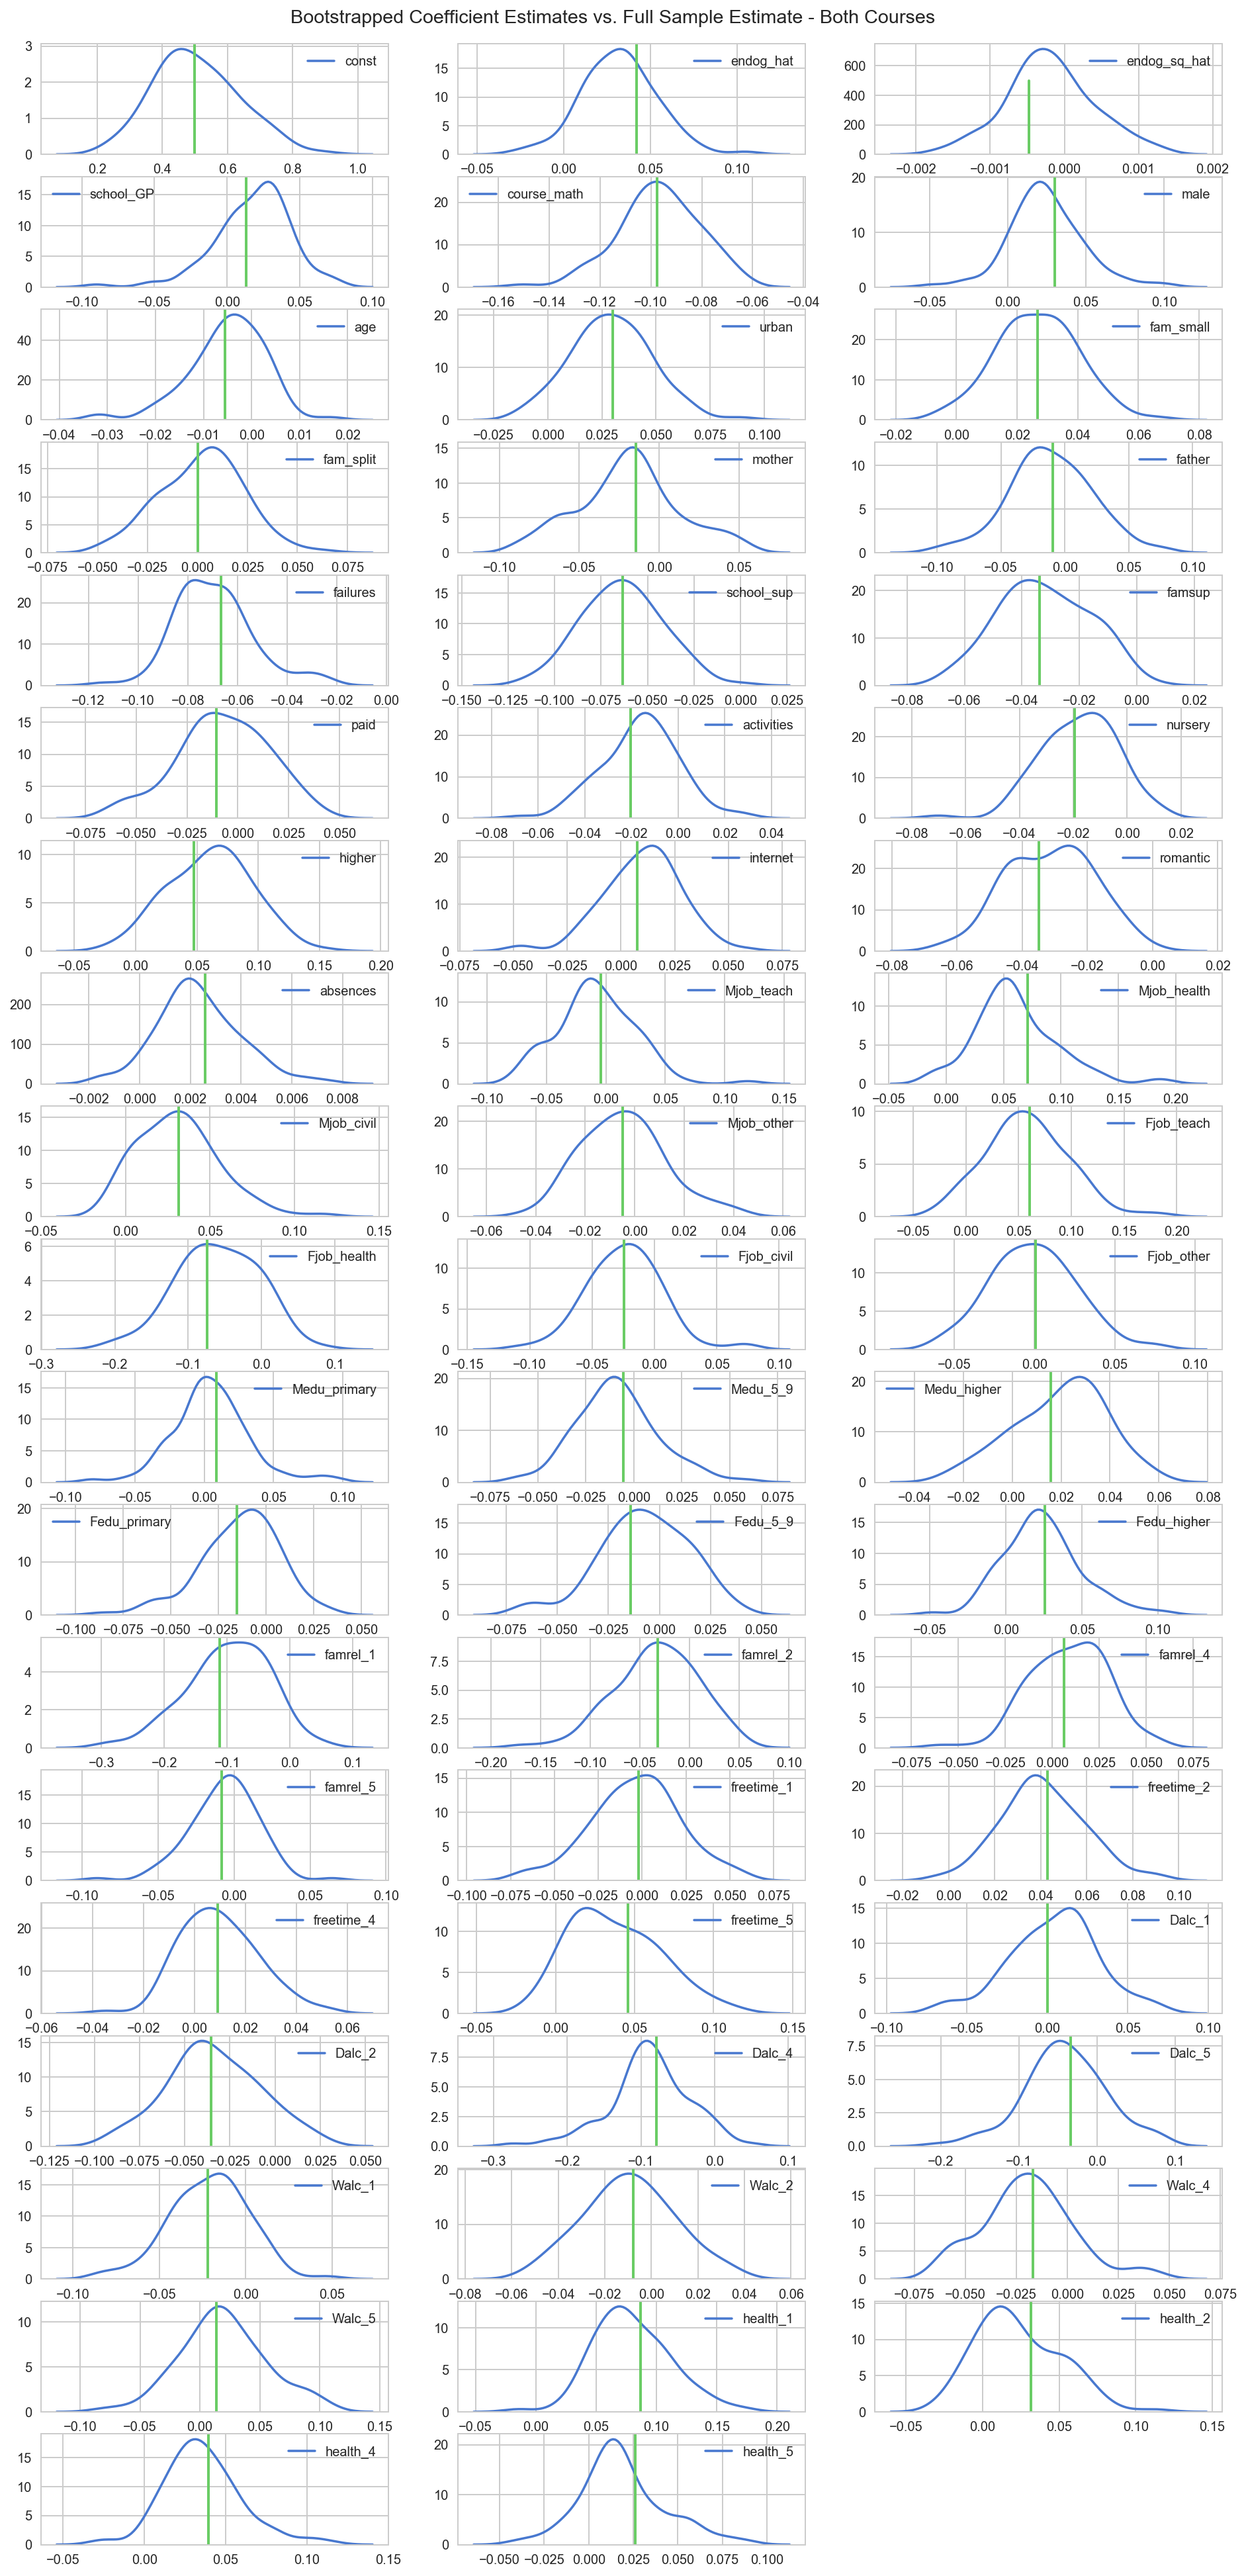

In [11]:
# Creating the plots - Both Courses
plt.figure(figsize=(16, 36))
sns.set(style="whitegrid", palette="muted", color_codes=True)

plt.subplots_adjust(top=0.97)
plt.suptitle('Bootstrapped Coefficient Estimates vs. Full Sample Estimate - Both Courses')

sns.despine()
for column_index, column in enumerate(resultsQ2SLS_both.X_hat.columns.values.tolist()):
    plt.subplot(22, 3, column_index + 1)
    sns.kdeplot(resultsQ2SLS_both.beta_hat_boots[column])
    plt.plot([resultsQ2SLS_both.result2.params[column_index], resultsQ2SLS_both.result2.params[column_index]], 
             [0, 500], 
             linewidth=2)
plt.savefig('figures/btsrp_coeffs_both.png', bbox_inches='tight');    

In [12]:
# Results - Portuguese Language Course
coeff_estms_Q2SLS_por = pd.DataFrame([resultsQ2SLS_por.result2.params, resultsQ2SLS_por.beta_hat_boots.mean(axis=0), resultsQ2SLS_por.beta_hat_boots_SE, resultsQ2SLS_por.beta_hat_boots_t, resultsQ2SLS_por.beta_hat_boots_p]).transpose()
coeff_estms_Q2SLS_por.columns = ['Full_Sample', 'Btrsp Avg', 'Btrsp SE', 'Btrsp t-val', 'Btrsp p-val']
coeff_estms_Q2SLS_por

,const,endog_hat,endog_sq_hat,school_GP,male,age,urban,fam_small,fam_split,mother,...,Dalc_4,Dalc_5,Walc_1,Walc_2,Walc_4,Walc_5,health_1,health_2,health_4,health_5
Full_Sample,0.348979,0.033158,-5.516905e-04,0.046229,-0.017942,0.003907,0.018990,0.017532,-0.010431,-0.020383,...,-0.113340,-0.034084,0.000788,0.014284,0.000050,0.021062,0.060746,0.035854,0.041623,0.007751
Bootstrapped,0.368124,0.016366,4.988749e-06,0.054759,-0.026106,0.005802,0.019262,0.017830,-0.008673,-0.031219,...,-0.126838,-0.030796,0.003677,0.010280,-0.007684,0.010564,0.052327,0.028449,0.038722,0.000561
Bootstrapped Var.,0.014003,0.000475,2.997411e-07,0.000507,0.000386,0.000053,0.000273,0.000232,0.000333,0.001080,...,0.005686,0.002656,0.000282,0.000387,0.000676,0.001662,0.000778,0.000708,0.000486,0.000678


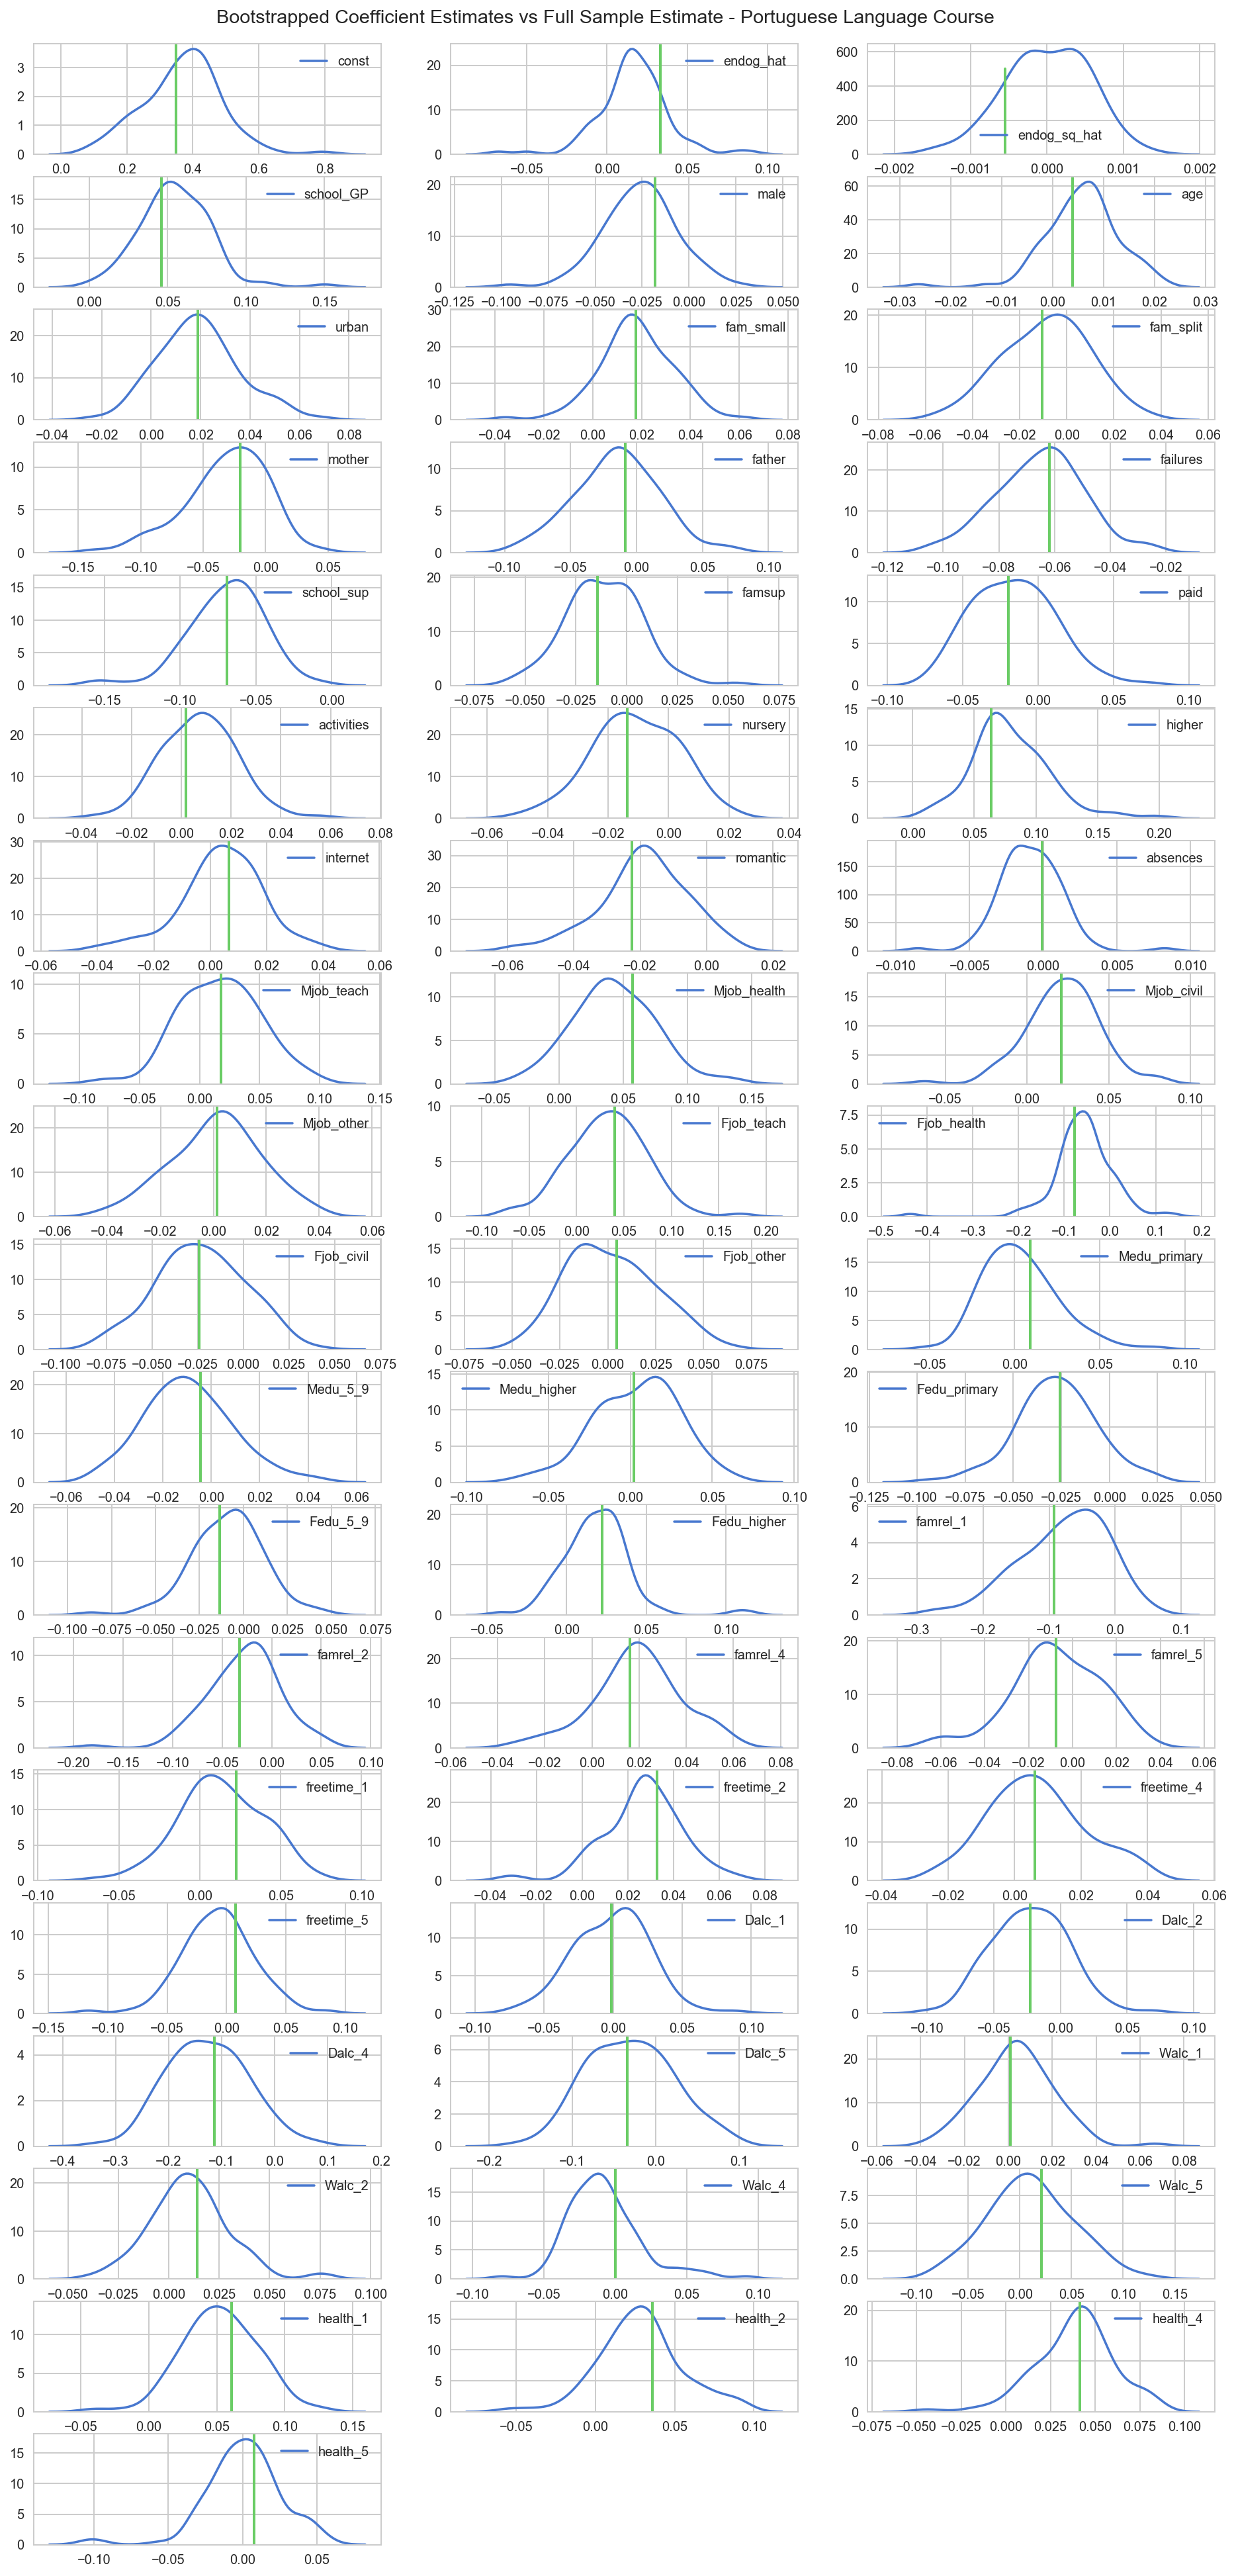

In [13]:
# Creating the plots - Portuguese Language Course
plt.figure(figsize=(16, 36))
sns.set(style="whitegrid", palette="muted", color_codes=True)

plt.subplots_adjust(top=0.97)
plt.suptitle('Bootstrapped Coefficient Estimates vs Full Sample Estimate - Portuguese Language Course')

sns.despine()
for column_index, column in enumerate(resultsQ2SLS_por.X_hat.columns.values.tolist()):
    plt.subplot(22, 3, column_index + 1)
    sns.kdeplot(resultsQ2SLS_por.beta_hat_boots[column])
    plt.plot([resultsQ2SLS_por.result2.params[column_index], resultsQ2SLS_por.result2.params[column_index]], 
             [0, 500], 
             linewidth=2)
plt.savefig('figures/btsrp_coeffs_por.png', bbox_inches='tight');     

In [14]:
# Results - Mathematics Course
coeff_estms_Q2SLS_mat = pd.DataFrame([resultsQ2SLS_mat.result2.params, resultsQ2SLS_mat.beta_hat_boots.mean(axis=0), resultsQ2SLS_mat.beta_hat_boots_SE, resultsQ2SLS_mat.beta_hat_boots_t, resultsQ2SLS_mat.beta_hat_boots_p]).transpose()
coeff_estms_Q2SLS_mat.columns = ['Full_Sample', 'Btrsp Avg', 'Btrsp SE', 'Btrsp t-val', 'Btrsp p-val']
coeff_estms_Q2SLS_mat

,const,endog_hat,endog_sq_hat,school_GP,male,age,urban,fam_small,fam_split,mother,...,Dalc_4,Dalc_5,Walc_1,Walc_2,Walc_4,Walc_5,health_1,health_2,health_4,health_5
Full_Sample,0.917412,0.021643,2.499023e-04,-0.048701,0.082637,-0.025340,0.037811,0.041532,0.010509,-0.043037,...,-0.081041,-0.021402,-0.050114,-0.048704,-0.063615,0.017356,0.081601,-0.010928,0.012162,0.018707
Bootstrapped,0.932239,0.018134,1.993937e-05,-0.041972,0.075150,-0.026081,0.027533,0.040803,0.007372,-0.048564,...,-0.087565,-0.004160,-0.039211,-0.050531,-0.067627,0.017263,0.079396,-0.012583,0.010416,0.014110
Bootstrapped Var.,0.123409,0.000896,6.507959e-07,0.003474,0.002317,0.000253,0.001863,0.000561,0.001402,0.002864,...,0.007981,0.013957,0.001861,0.001253,0.001344,0.004905,0.004089,0.002741,0.001496,0.001726


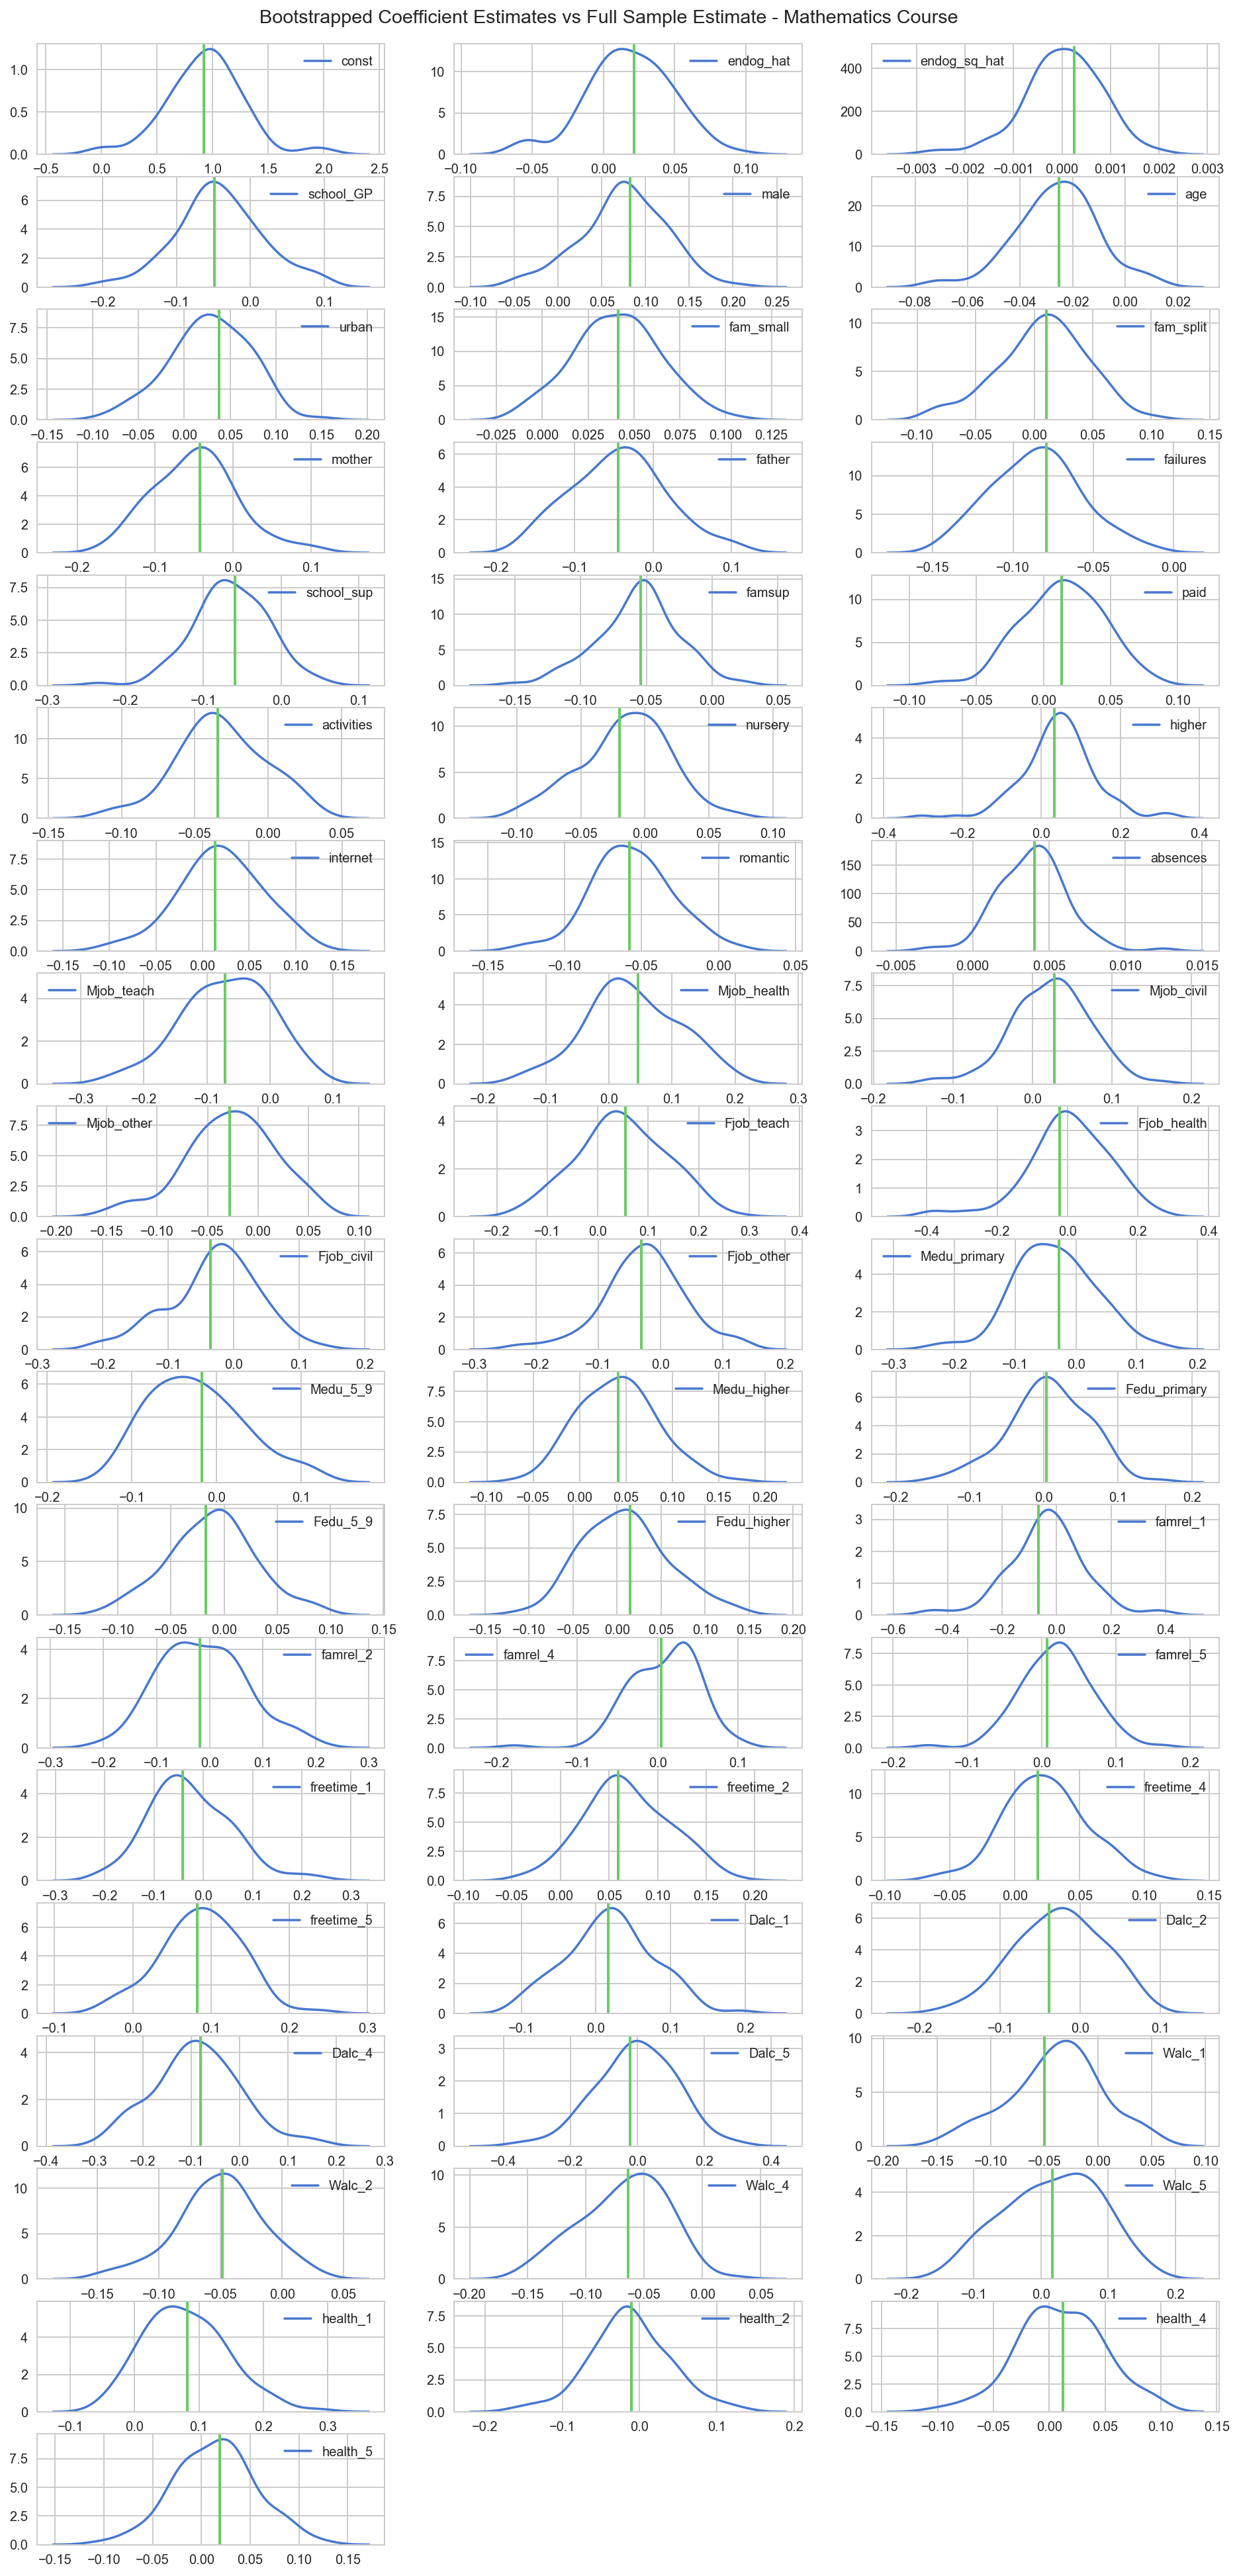

In [15]:
# Creating the plots - Mathematics Course
plt.figure(figsize=(16, 36))
sns.set(style="whitegrid", palette="muted", color_codes=True)

plt.subplots_adjust(top=0.97)
plt.suptitle('Bootstrapped Coefficient Estimates vs Full Sample Estimate - Mathematics Course')

sns.despine()
for column_index, column in enumerate(resultsQ2SLS_mat.X_hat.columns.values.tolist()):
    plt.subplot(22, 3, column_index + 1)
    sns.kdeplot(resultsQ2SLS_mat.beta_hat_boots[column])
    plt.plot([resultsQ2SLS_mat.result2.params[column_index], resultsQ2SLS_mat.result2.params[column_index]], 
             [0, 500], 
             linewidth=2)
plt.savefig('figures/btsrp_coeffs_mat.png', bbox_inches='tight');     

In [16]:
#saving 2 way SLS model to our results directory
#import pickle
#with open('results/2SLS.pkl','wb') as f:
#    pickle.dump(results,f)